In [1]:
import numpy as np
import matplotlib.pyplot as plt

from copy import copy
import scipy
from flux.shape import CgalTrimeshShapeModel, get_surface_normals, get_centroids, get_face_areas

import pyvista as pv
import colorcet as cc

In [2]:
max_area_str = "3.0"
outer_radius_str = "80"

V = np.load(f'examples/shackleton_vary_outer/shackleton_verts_{max_area_str}_{outer_radius_str}.npy')
F = np.load(f'examples/shackleton_vary_outer/shackleton_faces_{max_area_str}_{outer_radius_str}.npy')

# convert verts from km to m
V *= 1e3

N = get_surface_normals(V, F)
N[N[:, 2] > 0] *= -1

faces_padded = np.concatenate([3*np.ones(F.shape[0],dtype=int).reshape(-1,1), F], axis=1)

shape_model = CgalTrimeshShapeModel(V, F, N)
F.shape

(11125, 3)

# Oriented Bounding Box Trees (OBBTrees)

Using the clique based clustering, we would like to construct a hierarchical partioning of the triangular mesh. Typical quadtree partitioning used axis-aligned bounding boxe type of partitions, which was effective due to the typical uncomplicated geometries generated by that approach. However, the cliques can have strange shapes, and may need to be more intelligently partitioned.

### Extract the cliques from the uncompressed form factor matrix.

In [3]:
path = f"examples/shackleton_vary_outer/results/true_{max_area_str}_{outer_radius_str}/FF_{max_area_str}_{outer_radius_str}.npz"
FF_uncompressed = scipy.sparse.load_npz(path)

In [4]:
dmat = FF_uncompressed.A
FF_adj = np.zeros(FF_uncompressed.shape)
FF_adj[dmat >= np.quantile(dmat[dmat>0.], 0.0)] = 1.

all_pseudo_cliques = []
for i in np.random.permutation(FF_adj.shape[0]):
    
    # make sure the seed is not already in a clique
    if np.array([i in _pseudo_clique for _pseudo_clique in all_pseudo_cliques]).any():
        continue
    
    nonzero_idx = list((FF_adj[i] > 0).nonzero()[0])
    nonzero_idx.append(i)
    nonzero_idx = np.array(nonzero_idx)
    
    _nonzero_idx = []
    for j in nonzero_idx:
        
        if j == i:
            _nonzero_idx.append(j)
        
        elif not np.array([j in _pseudo_clique for _pseudo_clique in all_pseudo_cliques]).any():
            this_nonzero_idx = list((FF_adj[j] > 0).nonzero()[0])
            this_nonzero_idx.append(j)
            this_nonzero_idx = np.array(this_nonzero_idx)
            num_intersecting = np.intersect1d(nonzero_idx, this_nonzero_idx).shape[0]
            
            if num_intersecting >= 0.5*min(nonzero_idx.shape[0], this_nonzero_idx.shape[0]):
                _nonzero_idx.append(j)
    nonzero_idx = np.array(_nonzero_idx)
    
    pseudo_clique = set(list(np.copy(nonzero_idx)))    
    all_pseudo_cliques.append(pseudo_clique)
    
all_pseudo_clique_lists = []
for i in range(len(all_pseudo_cliques)):
    all_pseudo_clique_lists.append(np.array(list(all_pseudo_cliques[i])))
ordered_pseudo_clique_list = []
for new_idx in np.argsort([len(c) for c in all_pseudo_clique_lists])[::-1]:
    ordered_pseudo_clique_list.append(all_pseudo_clique_lists[new_idx])


culled_cliques = []

for i in range(25):    
    culled_cliques.append(np.copy(ordered_pseudo_clique_list[i]))
    
all_small_cliques = []
for i in range(25, len(ordered_pseudo_clique_list)):
    all_small_cliques += list(np.copy(ordered_pseudo_clique_list[i]))
culled_cliques.append(np.array(all_small_cliques))

current_clique_list = copy(culled_cliques)

if np.sum([len(this_clique) for this_clique in current_clique_list]) != FF_adj.shape[0]:
    raise RuntimeError("Cliques do not cover index set!")
else:
    print("Cliques cover index set!")

Cliques cover index set!


In [22]:
grid = pv.PolyData(V, faces=faces_padded.flatten(), n_faces=F.shape[0])

grid['Temp (Full FF)'] = np.empty(F.shape[0])
for i, I in enumerate(current_clique_list):
    grid['Temp (Full FF)'][I] = i
grid.plot(cmap=cc.cm.glasbey)

Widget(value="<iframe src='http://localhost:52868/index.html?ui=P_0x26cd6d6f6a0_3&reconnect=auto' style='width…

### Compute convex hull of vertices.

The oriented bounding box is defined with respect to the convex hull of the triangle vertices in the clique. In this example, we are looking at the clique corresponding to index 11.

In [147]:
grid = pv.PolyData(V, faces=faces_padded.flatten(), n_faces=F.shape[0])

grid['Temp (Full FF)'] = np.empty(F.shape[0])
for i, I in enumerate(current_clique_list):
    if i == 11:
        grid['Temp (Full FF)'][I] = 1
    else:
        grid['Temp (Full FF)'][I] = 0
grid.plot(cmap=cc.cm.glasbey)

Widget(value="<iframe src='http://localhost:52868/index.html?ui=P_0x26dcda57a00_40&reconnect=auto' style='widt…

In [112]:
def get_triangle_vertices(shape_model, triangle_idx):
    '''
    Return tensor where first dimension is the number
    of triangles, second dimension corresponds to each
    vertex of the triangle, and third dimension contains
    the spatial coordinates of a vertex.
    '''
    vertices_idx = shape_model.F[triangle_idx]
    return shape_model.V[vertices_idx]

In [148]:
clique_vertices = get_triangle_vertices(shape_model, current_clique_list[11])[:,:,:2]
clique_vertices_flat = clique_vertices.reshape(-1,2)
clique_vertices.shape, clique_vertices_flat.shape

((131, 3, 2), (393, 2))

In [149]:
clique_triangle_areas = get_face_areas(shape_model.V, shape_model.F[current_clique_list[11]])
clique_triangle_areas.shape

(131,)

In [150]:
hull = scipy.spatial.ConvexHull(clique_vertices_flat)

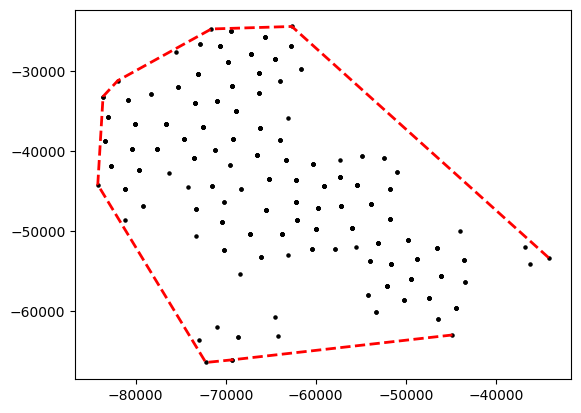

In [151]:
plt.scatter(clique_vertices_flat[:,0], clique_vertices_flat[:,1], s=5, c='k')

plt.plot(clique_vertices_flat[hull.vertices,0], clique_vertices_flat[hull.vertices,1], 'r--', lw=2)

### Compute the principal components of the convex hull.

First, densely sample the interior of the convex hull defined by the clique triangle vertices. Then, the eigenvectors of the covariance matrix of these sampled points can define the axes of the oriented box containing the clique.

In [152]:
num_samples = 1000

hull_deln_simplices = scipy.spatial.Delaunay(clique_vertices_flat[hull.vertices]).simplices
hull_deln_simplex_coords = clique_vertices_flat[hull.vertices][hull_deln_simplices]
hull_deln_areas = np.abs(np.linalg.det(hull_deln_simplex_coords[:, :2, :] - hull_deln_simplex_coords[:, 2:, :])) / np.math.factorial(2)
sampled_deln_triangles = np.random.choice(len(hull_deln_areas), size = num_samples, p = hull_deln_areas / hull_deln_areas.sum())
sampled_interior = np.einsum('ijk, ij -> ik', hull_deln_simplex_coords[sampled_deln_triangles], scipy.stats.dirichlet.rvs([1]*(2 + 1), size = num_samples))
sampled_interior.shape

(1000, 2)

In [153]:
mu = sampled_interior.mean(axis=0)
cov = np.cov(sampled_interior.T)

In [154]:
_, eigvecs = np.linalg.eig(cov)
eigvecs.shape

(2, 2)

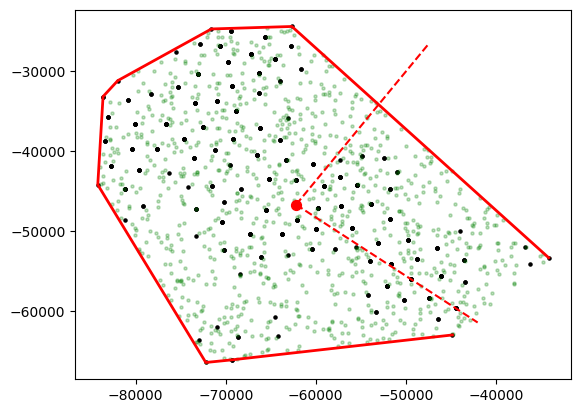

In [156]:
plt.scatter(clique_vertices_flat[:,0], clique_vertices_flat[:,1], s=5, c='k')
plt.scatter(sampled_interior[:,0], sampled_interior[:,1], s=5, c='g', alpha=0.25)

plt.scatter(mu[0], mu[1],color='r',s=50)

plt.plot([mu[0], mu[0] + 2.5e4*eigvecs[0, 0]], [mu[1], mu[1] + 2.5e4*eigvecs[1, 0]], color='r', ls='--')
plt.plot([mu[0], mu[0] + 2.5e4*eigvecs[0, 1]], [mu[1], mu[1] + 2.5e4*eigvecs[1, 1]], color='r', ls='--')

plt.plot(clique_vertices_flat[hull.vertices,0], clique_vertices_flat[hull.vertices,1], color='r', lw=2)
plt.show()

### Partition the space according to the lines (planes) defined by the eigenvectors.

In [158]:
plane1 = np.array([(eigvecs[1,0]/eigvecs[0,0]), -1, (-1*(eigvecs[1,0]/eigvecs[0,0])*mu[0]) + mu[1]])
plane2 = np.array([(eigvecs[1,1]/eigvecs[0,1]), -1, (-1*(eigvecs[1,1]/eigvecs[0,1])*mu[0]) + mu[1]])

padded_clique_vertices_flat = np.concatenate([clique_vertices_flat,np.ones((clique_vertices_flat.shape[0],1))], axis=1)

In [159]:
plane1_dot = (plane1 * padded_clique_vertices_flat).sum(axis=1) > 0
plane2_dot = (plane2 * padded_clique_vertices_flat).sum(axis=1) > 0

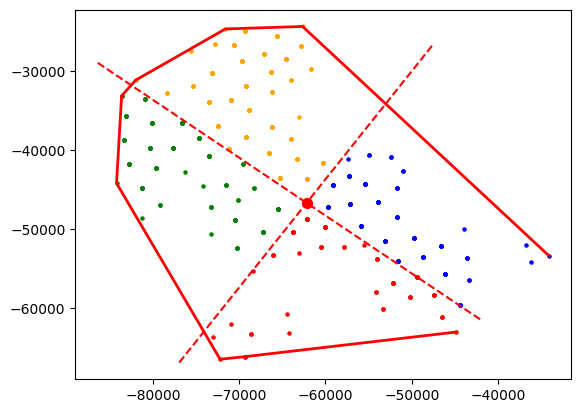

In [160]:
plt.scatter(clique_vertices_flat[np.logical_and(plane1_dot, plane2_dot),0], clique_vertices_flat[np.logical_and(plane1_dot, plane2_dot),1], s=5, c='r')
plt.scatter(clique_vertices_flat[np.logical_and(plane1_dot, ~plane2_dot),0], clique_vertices_flat[np.logical_and(plane1_dot, ~plane2_dot),1], s=5, c='g')
plt.scatter(clique_vertices_flat[np.logical_and(~plane1_dot, plane2_dot),0], clique_vertices_flat[np.logical_and(~plane1_dot, plane2_dot),1], s=5, c='b')
plt.scatter(clique_vertices_flat[np.logical_and(~plane1_dot, ~plane2_dot),0], clique_vertices_flat[np.logical_and(~plane1_dot, ~plane2_dot),1], s=5, c='orange')

plt.scatter(mu[0], mu[1],color='r',s=50)

plt.plot([mu[0] - 3e4*eigvecs[0, 0], mu[0], mu[0] + 2.5e4*eigvecs[0, 0]], [mu[1] - 3e4*eigvecs[1, 0], mu[1], mu[1] + 2.5e4*eigvecs[1, 0]], color='r', ls='--')
plt.plot([mu[0] - 2.5e4*eigvecs[0, 1], mu[0], mu[0] + 2.5e4*eigvecs[0, 1]], [mu[1] - 2.5e4*eigvecs[1, 1], mu[1], mu[1] + 2.5e4*eigvecs[1, 1]], color='r', ls='--')

plt.plot(clique_vertices_flat[hull.vertices,0], clique_vertices_flat[hull.vertices,1], color='r', lw=2)
plt.show()

### Visualize the partitioning of this clique on the mesh.

In [162]:
P = get_centroids(shape_model.V, shape_model.F)
clique_centroids = P[current_clique_list[11]][:,:2]
padded_clique_centroids = np.concatenate([clique_centroids,np.ones((clique_centroids.shape[0],1))], axis=1)
padded_clique_centroids.shape

(131, 3)

In [164]:
clique_branches = []

plane1_dot = (plane1 * padded_clique_centroids).sum(axis=1) > 0
plane2_dot = (plane2 * padded_clique_centroids).sum(axis=1) > 0

clique_branches.append(np.where(np.logical_and(plane1_dot, plane2_dot))[0])
clique_branches.append(np.where(np.logical_and(~plane1_dot, plane2_dot))[0])
clique_branches.append(np.where(np.logical_and(plane1_dot, ~plane2_dot))[0])
clique_branches.append(np.where(np.logical_and(~plane1_dot, ~plane2_dot))[0])

clique_branches_modified = []
for i in range(4):
    clique_branches_modified.append(current_clique_list[11][clique_branches[i]])

grid = pv.PolyData(V, faces=faces_padded.flatten(), n_faces=F.shape[0])

grid['Temp (Full FF)'] = np.empty(F.shape[0])
grid['Temp (Full FF)'][...] = 0
counter = 5
for i, I in enumerate(clique_branches_modified):
    grid['Temp (Full FF)'][I] = counter
    counter += 1
grid.plot(cmap=cc.cm.glasbey)

Widget(value="<iframe src='http://localhost:52868/index.html?ui=P_0x26dc19e2440_42&reconnect=auto' style='widt…

### Compare to axis-aligned bounding box type of partitioning.

In [26]:
from flux.quadtree import get_quadrant_order

def get_obb_partition_2d(I, shape_model, num_samples=1000):

    # get the vertices of all indexed triangles
    vertices_idx = shape_model.F[I]
    cluster_vertices = shape_model.V[vertices_idx]
    cluster_vertices = cluster_vertices[:,:,:2]
    cluster_vertices_flat = cluster_vertices.reshape(-1,2)

    # compute the convex hull of the triangle vertices
    hull = scipy.spatial.ConvexHull(cluster_vertices_flat)

    # sample point over the surface of the convex hull
    hull_deln_simplices = scipy.spatial.Delaunay(cluster_vertices_flat[hull.vertices]).simplices
    hull_deln_simplex_coords = cluster_vertices_flat[hull.vertices][hull_deln_simplices]
    hull_deln_areas = np.abs(np.linalg.det(hull_deln_simplex_coords[:, :2, :] - hull_deln_simplex_coords[:, 2:, :])) / np.math.factorial(2)
    sampled_deln_triangles = np.random.choice(len(hull_deln_areas), size=num_samples, p=hull_deln_areas/hull_deln_areas.sum())
    sampled_interior = np.einsum('ijk, ij -> ik', hull_deln_simplex_coords[sampled_deln_triangles], scipy.stats.dirichlet.rvs([1]*(2 + 1), size=num_samples))
    
    # compute the mean and covariance of the sample
    mu = sampled_interior.mean(axis=0)
    cov = np.cov(sampled_interior.T)

    # eigenvectors of covariance define partition
    _, eigvecs = np.linalg.eig(cov)
    plane1 = np.array([(eigvecs[1,0]/eigvecs[0,0]), -1, (-1*(eigvecs[1,0]/eigvecs[0,0])*mu[0]) + mu[1]])
    plane2 = np.array([(eigvecs[1,1]/eigvecs[0,1]), -1, (-1*(eigvecs[1,1]/eigvecs[0,1])*mu[0]) + mu[1]])

    # centroids determine partition
    P = get_centroids(shape_model.V, shape_model.F)
    cluster_centroids = P[I,:2]
    padded_cluster_centroids = np.concatenate([cluster_centroids,np.ones((cluster_centroids.shape[0],1))], axis=1)
    plane1_dot = (plane1 * padded_cluster_centroids).sum(axis=1) > 0
    plane2_dot = (plane2 * padded_cluster_centroids).sum(axis=1) > 0
    
    Is = []
    Is.append(np.where(np.logical_and(plane1_dot, plane2_dot))[0])
    Is.append(np.where(np.logical_and(~plane1_dot, plane2_dot))[0])
    Is.append(np.where(np.logical_and(plane1_dot, ~plane2_dot))[0])
    Is.append(np.where(np.logical_and(~plane1_dot, ~plane2_dot))[0])
    return Is

In [138]:
selected_clique = 11

selected_I = current_clique_list[selected_clique]
print(selected_I.max(), selected_I.shape)

grid = pv.PolyData(V, faces=faces_padded.flatten(), n_faces=F.shape[0])

grid['Selected Clique'] = np.empty(F.shape[0])
for i, I in enumerate(current_clique_list):
    if i == selected_clique:
        grid['Selected Clique'][I] = 1
    else:
        grid['Selected Clique'][I] = 10
grid.plot(cmap=cc.cm.glasbey)

11050 (131,)


Widget(value="<iframe src='http://localhost:52868/index.html?ui=P_0x26dcda565c0_37&reconnect=auto' style='widt…

In [139]:
shape_model.P
PI = P[selected_I, :2]
Is = [I for I in get_quadrant_order(PI)]
Is_modified = []
for i in range(len(Is)):
    Is_modified.append(selected_I[Is[i]])

In [140]:
Is_obb = get_obb_partition_2d(selected_I, shape_model, num_samples=1000)
Is_obb_modified = []
for i in range(len(Is_obb)):
    Is_obb_modified.append(selected_I[Is_obb[i]])

In [141]:
np.concatenate(Is_modified).max(), np.concatenate(Is_modified).shape

(11050, (131,))

In [142]:
print(np.var([len(I) for I in Is_modified]))
[len(I) for I in Is_modified]

441.1875


[23, 66, 33, 9]

In [143]:
np.concatenate(Is_obb_modified).max(), np.concatenate(Is_obb_modified).shape

(11050, (131,))

In [144]:
print(np.var([len(I) for I in Is_obb_modified]))
[len(I) for I in Is_obb_modified]

61.1875


[21, 33, 34, 43]

In [145]:
grid = pv.PolyData(V, faces=faces_padded.flatten(), n_faces=F.shape[0])

grid['Quadtree Partition'] = np.empty(F.shape[0])
grid['Quadtree Partition'][...] = 10
counter = 5
for i, I in enumerate(Is_modified):
    grid['Quadtree Partition'][I] = counter
    counter += 1
grid.plot(cmap=cc.cm.glasbey)

Widget(value="<iframe src='http://localhost:52868/index.html?ui=P_0x26dcda54df0_38&reconnect=auto' style='widt…

In [146]:
grid = pv.PolyData(V, faces=faces_padded.flatten(), n_faces=F.shape[0])

grid['OBBtree Partition'] = np.empty(F.shape[0])
grid['OBBtree Partition'][...] = 10
counter = 5
for i, I in enumerate(Is_obb_modified):
    grid['OBBtree Partition'][I] = counter
    counter += 1
grid.plot(cmap=cc.cm.glasbey)

Widget(value="<iframe src='http://localhost:52868/index.html?ui=P_0x26dcda55a80_39&reconnect=auto' style='widt…